# **Neural steering controller for an artificial race driver (ARD)**

This tutorial implements the physics-driven neural steering controller in Fig. 8a of the paper titled:

*A Physics-Driven Artificial Agent for Online Time-Optimal Vehicle Motion Planning and Control*

(available at https://ieeexplore.ieee.org/abstract/document/101225395)

This NN controls the pure lateral steering dynamics of a race car. 

## Initialization

### Import packages

In [10]:
import sys
import os
import torch
import pandas as pd
import scipy as sp

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from neu4mes import *
from neu4mes import relation
from neu4mes import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials


### Configurations and known constant parameters

In [11]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'datasets','control_steer_artificial_race_driver')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map_values = np.float64(np.deg2rad(steer_map_load[:,0]))
delta_w_avg_map_values = delta_w_avg_map_values[:,np.newaxis].tolist()  # add a dimension
delta_sw_map_values = np.float64(np.deg2rad(steer_map_load[:,1]))
delta_sw_map_values = delta_sw_map_values[:,np.newaxis].tolist()  # add a dimension

## NN model

### Custom parametric functions

In [12]:
# -------------------------------------------------
# Normalization function
# -------------------------------------------------
def normalize_fun(x,x_max):
  return x/x_max

# -------------------------------------------------
# Absolute value function
# -------------------------------------------------
def abs_fun(x):
  return torch.abs(x)

# -------------------------------------------------
# Handling diagram
# -------------------------------------------------
def handling_diagr_local(curv,ay,vx_norm,  # inputs
                         ay_0,L,           # constants
                         k1_vx,k2_vx       # learnable arrays of parameters
                         ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # compute k1, as a function of vx 
  k1_vx_fun = k1_vx[0,0,0]
  for ii in range(1,k1_vx.size(2)):
    k1_vx_fun = k1_vx_fun + k1_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # compute k2, as a function of vx
  k2_vx_fun = k2_vx[0,0,0]
  for ii in range(1,k2_vx.size(2)):
    k2_vx_fun = k2_vx_fun + k2_vx[0,0,ii]*torch.pow(vx_norm,ii)
    
  # output of the local model of the handling diagram
  output = curv*L + k1_vx_fun*sign_ay + k2_vx_fun*(ay - ay_0*sign_ay)
  return output

### Internal architecture

In [13]:
relation.NeuObj_names = []  # reset the list of NeuObj names

# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
curv         = Input('curv')          # [1/m] path curvature
vx           = Input('vx')            # [m/s] longitudinal velocity  
ay           = Input('ay')            # [m/s^2] lateral acceleration
steer        = Input('steer')         # [rad] steering wheel angle 
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

# Load the training and validation data
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')
# Extract the max values of ay and vx from the training set
max_ay_train = max(abs(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['ay'].values))
min_vx_train = min(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values)
max_vx_train = max(pd.read_csv(os.path.join(data_folder_train,'telem_train.csv'))['u'].values)

# -----------------------------------------------
# Hyperparameters
# -----------------------------------------------
# Window size for the inputs
num_samples_future_feedfw = 15   # number of future samples in the feedforward part of the model
num_samples_past_steer    = 15   # number of samples in the past for the steering wheel angle prediction

# Number of channels for the lateral acceleration ay
num_channels_ay = 7
chan_centers_ay = list(np.linspace(0.0, max_ay_train + 1.0, num_channels_ay))  # centers of the channels

# Number of channels for forward speed
num_channels_vx = 7
chan_centers_vx = list(np.linspace(min_vx_train, max_vx_train, num=num_channels_vx))  # centers of the channels

# Degree of the polynomial to fit k1, as a function of vx
poly_degree_k1_vx = 3
# Degree of the polynomial to fit k2, as a function of vx
poly_degree_k2_vx = 1

# -----------------------------------------------
# Initial guesses and constants
# -----------------------------------------------
# Load the initial guesses for the handling diagram model, computed in Matlab with a 2nd order optimizer
initial_guesses_handling_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_handling_diagram',
                                                            str(num_channels_ay) + '_lin_models_ay_poly_deg_' + 
                                                            str(poly_degree_k1_vx) + '_' + str(poly_degree_k2_vx) + '_vx.mat'))
k1_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k1_vx'][0][0][0]
k2_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k2_vx'][0][0][0]

# Non-trainable parameters:
# Vehicle data
L = Constant('L',values=pd.read_csv(vehicle_data_csv)['L'][0])  # [m] wheelbase

# -----------------------------------------------
# Pre-process the inputs
# -----------------------------------------------
vx_norm = ParamFun(normalize_fun)(vx.sw([0,num_samples_future_feedfw]),max_vx_train.item())  # normalized longitudinal velocity
ay_abs  = ParamFun(abs_fun)(ay.sw([0,num_samples_future_feedfw]))  # absolute value of the lateral acceleration

# -----------------------------------------------
# Local models of the handling diagram, 
# to model the steady-state pure lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_ay = Fuzzify(centers=chan_centers_ay, functions='Triangular')(ay_abs)

# Define the input function for the LocalModel object.
# There are multiple ways to define this function. An important thing to be considered is that each local model needs its own 
# initial guesses, which are passed as external parameters to the function.
# One possibility is to define the function in the following way, which will create the function handling_diagr_gen several times
# in the json file. This is not the most efficient way, but it is the most straightforward way to define the function.
# def handling_diagr_gen(idx_list):
#   idx = idx_list[0]
#   ay_0 = Constant('ay_center_' + str(idx),values=chan_centers_ay[idx])  # center of the channel
#   k1_vx_guess = Parameter('k1_vx_' + str(idx),values=[[k1_vx_array_guess[idx*(poly_degree_k1_vx+1):(idx+1)*(poly_degree_k1_vx+1)]]])  # initial guess
#   k2_vx_guess = Parameter('k2_vx_' + str(idx),values=[[k2_vx_array_guess[idx*(poly_degree_k2_vx+1):(idx+1)*(poly_degree_k2_vx+1)]]])  # initial guess
#   handling_diagr = ParamFun(handling_diagr_local,
#                             constants=[ay_0,L],
#                             parameters=[k1_vx_guess,k2_vx_guess])
#   return handling_diagr

# Another possibility is to define the function handling_diagr_gen only once, and then call it with its parameters for each channel.
handling_diagr = ParamFun(handling_diagr_local)

# Handling diagram function generator
def handling_diagr_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def handling_diagr_map(curv,ay,vx_norm):
    idx  = idx_list[0]  # index of the channel
    ay_0 = Constant('ay_center_' + str(idx),values=chan_centers_ay[idx])  # center of the channel
    k1_vx_guess = Parameter('k1_vx_' + str(idx),values=[[k1_vx_array_guess[idx*(poly_degree_k1_vx+1):(idx+1)*(poly_degree_k1_vx+1)]]])  # initial guess
    k2_vx_guess = Parameter('k2_vx_' + str(idx),values=[[k2_vx_array_guess[idx*(poly_degree_k2_vx+1):(idx+1)*(poly_degree_k2_vx+1)]]])  # initial guess
    return handling_diagr(curv,ay,vx_norm,ay_0,L,k1_vx_guess,k2_vx_guess)
  return handling_diagr_map

out_local_models_handling_diagr = LocalModel(input_function=handling_diagr_gen, pass_indexes=True)((curv.sw([0,num_samples_future_feedfw]),
                                                                                                    ay.sw([0,num_samples_future_feedfw]),
                                                                                                    vx_norm),
                                                                                                    activ_fcns_ay)

# -----------------------------------------------
# Local models for the transient lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_vx = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw([0,num_samples_future_feedfw]))

# Define and call the local model for the transient dynamics
local_model_trans_dyna = LocalModel(output_function=lambda: Fir(parameter_init = init_exp, 
                                                                parameter_init_params={'size_index':0, 'max_value':0.1, 
                                                                                       'lambda':5, 'monotonicity':'decreasing'}))
out_local_model_trans_dyna = local_model_trans_dyna(out_local_models_handling_diagr, activ_fcns_vx)

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
delta_w_avg_map = Constant('delta_w_avg_map',values=delta_w_avg_map_values)  # [rad] average steering angle at the front wheels
delta_sw_map    = Constant('delta_sw_map',values=delta_sw_map_values)        # [rad] steering wheel angle
out_steer_map   = ParamFun(linear_interp, 
                           constants=[delta_w_avg_map,delta_sw_map],
                           map_over_batch=False)(out_local_model_trans_dyna)    # map_over_batch=True is used to apply the function to each sample in the batch

# FIR layer to weigh the past steering wheel angles computed by the NN (auto-regressive model)
out_arx = Fir(parameter='fir_auto_regression', parameter_init=init_exp, 
              parameter_init_params={'size_index':0, 'max_value':1e-3, 'lambda':5, 'monotonicity':'increasing'})(steer.sw([-num_samples_past_steer,0]))  

# We define two neural models: 
# --> a model without the auto-regression (feed-forward model, which will be trained in open-loop) 
# --> a model with the auto-regression (it will be trained in closed-loop)
out_no_arx   = Output('steering_angle', out_steer_map)            # output of the feed-forward model (no auto-regression)    
out_with_arx = Output('steering_angle', out_steer_map + out_arx)  # output of the model with auto-regression

### Neu4Mes definitions

In [14]:
# Create a neu4mes model
path_folder_no_arx   = os.path.join(os.getcwd(),'trained_models','steer_controller_no_arx')    # folder to save the model without auto-regression
path_folder_with_arx = os.path.join(os.getcwd(),'trained_models','steer_controller_with_arx')  # folder to save the model with auto-regression
steer_controller_no_arx   = Neu4mes(visualizer='Standard',seed=12,workspace=path_folder_no_arx,save_history=False)  #visualizer=MPLVisulizer()
steer_controller_with_arx = Neu4mes(visualizer='Standard',seed=12,workspace=path_folder_with_arx,save_history=False)  

# Add the neural model to the neu4mes structure and neuralization of the model
steer_controller_no_arx.addModel('steer_ctrl',[out_no_arx])
steer_controller_no_arx.addMinimize('steer_error', 
                                    steer_target.next(),  # next means the first value in the "future"
                                    out_no_arx, 
                                    loss_function='mse')

steer_controller_with_arx.addModel('steer_ctrl',[out_with_arx])
steer_controller_with_arx.addMinimize('steer_error', 
                                      steer_target.next(),  # next means the first value in the "future"
                                      out_with_arx, 
                                      loss_function='mse')

#### Create the model with no auto-regression

In [15]:
steer_controller_no_arx.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant55': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                   

#### Create the model with the auto-regression

In [16]:
steer_controller_with_arx.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant55': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                   

## Training and validation datasets

In [17]:
# Pass the training and the validation datasets to the neu4mes structure
data_struct_no_arx = ['','steer_target','curv','vx','ay']  
steer_controller_no_arx.loadData(name='training_set', source=data_folder_train, format=data_struct_no_arx, skiplines=1)
steer_controller_no_arx.loadData(name='validation_set', source=data_folder_valid, format=data_struct_no_arx, skiplines=1)

data_struct_with_arx = ['',('steer','steer_target'),'curv','vx','ay']  # both steer and steer_target are read from the same column of the csv file
steer_controller_with_arx.loadData(name='training_set', source=data_folder_train, format=data_struct_with_arx, skiplines=1)
steer_controller_with_arx.loadData(name='validation_set', source=data_folder_valid, format=data_struct_with_arx, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_no_arx.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

[loadData] Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/control_steer_artificial_race_driver/training/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 training_set
Number of files:              2
Total number of samples:      5600
Shape of vx:                  (5600, 15, 1)
Shape of ay:                  (5600, 15, 1)
Shape of curv:                (5600, 15, 1)
Shape of steer_target:        (5600, 1, 1)
[loadData] Cannot read file /Users/mattiapiccinini/Documents/Research/Neu4Mes/Neu4Mes/tutorials/datasets/control_steer_artificial_race_driver/validation/.DS_Store
============================ Neu4mes Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              2
Total number of samples:      4581
Shape of vx:                  (4581, 15, 1)
Shape of ay:                  (4581, 15, 1)
Shape of curv:               

## Training

### Train the feed-forward NN (no auto-regression) in open-loop 

In [18]:
num_epochs = 6000
batch_size = 200
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result_open_loop = steer_controller_no_arx.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                              training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                    'error':'steer_error'})  
else:
  # Load the trained model
  steer_controller_no_arx.loadModel() 

======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                6000
update per epochs:            28.0
update per epochs=(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 100}
train dataset:                training_set
 - num of samples:            5600
 - batch size:                200
 - unused samples:            0.0
unused samples=n_samples-update_per_epochs*batch_size
val dataset:                  validation_set
val {batch size, samples}:    {200, 4581}
minimizers:                   {'steer_error': {'A': 'SamplePart285',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:        

In [19]:
# Print the trained NN parameters
steer_controller_no_arx.neuralizeModel()

if flag_train_now:
  # Save the trained model
  steer_controller_no_arx.saveModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant55': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                   

#### Test on a new dataset

MSE on the test set:  [0.00049081]  rad^2


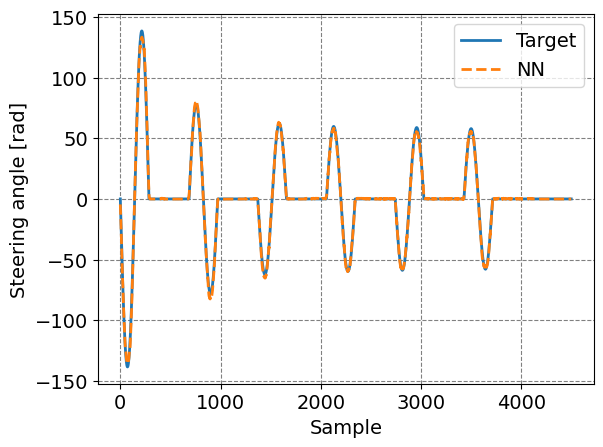

In [20]:
# Test on a new dataset
num_samples_use  = 4500
samples_test_set = steer_controller_no_arx.getSamples('validation_set', index=0, window=num_samples_use) 
out_nn_test_set  = steer_controller_no_arx(samples_test_set, sampled=True)
out_nn_test_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = mse_calc/len(samples_test_set_extract)
print('MSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(np.rad2deg(samples_test_set_extract),label='Target',linewidth=2)
  plt.plot(np.rad2deg(out_nn_test_set_extract),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#steer_controller_ARD({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})

### Train the NN with auto-regression in open-loop (the auto-regressive term is computed using the dataset)

In [21]:
num_epochs = 6000
batch_size = 200
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars_open_loop = {'num_of_epochs':num_epochs, 
                           'val_batch_size':batch_size, 
                           'train_batch_size':batch_size, 
                           'lr':learn_rate}

train_result_open_loop = steer_controller_with_arx.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                              training_params=training_pars_open_loop, optimizer='Adam', shuffle_data=True,
                                                              early_stopping=earlystopping.early_stop_patience,  
                                                              early_stopping_params={'patience':early_stop_patience,
                                                                                     'error':'steer_error'})  

======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                6000
update per epochs:            27.925
update per epochs=(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 100}
train dataset:                training_set
 - num of samples:            5585
 - batch size:                200
 - unused samples:            0.0
unused samples=n_samples-update_per_epochs*batch_size
val dataset:                  validation_set
val {batch size, samples}:    {200, 4566}
minimizers:                   {'steer_error': {'A': 'SamplePart287',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:      

In [22]:
# Print the trained NN parameters
steer_controller_with_arx.neuralizeModel()

# Save the trained model
steer_controller_with_arx.saveModel()

# Load the trained model
# steer_controller_with_arx.loadModel() 

================================ Neu4mes Model =================================
{'Constants': {'Constant55': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                   

### Re-train the NN in auto-regressive mode (closed-loop training)

In [23]:
flag_closed_loop_train = True

if flag_closed_loop_train:
  num_epochs = 1000
  batch_size = 500
  learn_rate = 1e-3  # learning rate
  early_stop_patience = 50
  training_pars_closed_loop = {'num_of_epochs':num_epochs, 
                               'val_batch_size':batch_size, 
                               'train_batch_size':batch_size, 
                               'lr':learn_rate}

  predict_samples = 40  # number of samples after which the internal state is reset
  steps_skip = predict_samples #1  # number of samples to skip when going to a new window. The default is 1, meaning the size of a batch. If steps_skip = predict_samples, then the whole window size is skipped

  # NOTE: by default, the next batch skips a full length of a batch
  # NOTE: shuffle = True shuffles only the order of the batches, so it's ok with the autoregression

  train_result_closed_loop = steer_controller_with_arx.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                                                  training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=False,
                                                                  early_stopping=earlystopping.early_stop_patience, 
                                                                  early_stopping_params={'patience':early_stop_patience,
                                                                                         'error':'steer_error'},
                                                                  prediction_samples=predict_samples, step=steps_skip, 
                                                                  closed_loop={'steer':'steering_angle'})  

[trainModel] Recurrent train: closing the loop between the the input ports steer and the output ports steering_angle for 40 samples
======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                1000
update per epochs:            10
update per epochs=(n_samples-batch_size-prediction_samples+1)/(batch_size+step-1)+1
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 50}
prediction samples:           40
step:                         40
closed loop:                  {'steer': 'steering_angle'}
connect:                      {}
train dataset:                training_set
 - num of samples:            5585
 - batch size:                500
 - unused samples:            194
unused samples=n_samples-prediction_samples-update_per_epochs*(batch_size+step-1)
val dataset:                  validation_set
val {batch size, samples}:    {500, 456

### Print the parameters of the trained NN + export the model

In [24]:
# Print the trained NN parameters
steer_controller_with_arx.neuralizeModel()

# Save the trained model
steer_controller_with_arx.saveModel()

# Load the trained model
# steer_controller_with_arx.loadModel() 

================================ Neu4mes Model =================================
{'Constants': {'Constant55': {'dim': 1, 'values': 90.34050057876874},
               'L': {'dim': 1, 'values': 2.649},
               'ay_center_0': {'dim': 1, 'values': 0.0},
               'ay_center_1': {'dim': 1, 'values': 2.2793929833881674},
               'ay_center_2': {'dim': 1, 'values': 4.558785966776335},
               'ay_center_3': {'dim': 1, 'values': 6.838178950164503},
               'ay_center_4': {'dim': 1, 'values': 9.11757193355267},
               'ay_center_5': {'dim': 1, 'values': 11.396964916940837},
               'ay_center_6': {'dim': 1, 'values': 13.676357900329004},
               'delta_sw_map': {'dim': 1,
                                'sw': 100,
                                'values': [[-5.646462110062002],
                                           [-5.539048665195617],
                                           [-5.431635289433799],
                                   

## Test on a new dataset

In [25]:
# Test on a new dataset
num_samples_use  = 4500
samples_test_set = steer_controller_with_arx.getSamples('validation_set', index=0, window=num_samples_use) 
steer_controller_with_arx.resetStates()  # reset the internal state
out_nn_test_set         = steer_controller_with_arx(samples_test_set, sampled=True, 
                                                    prediction_samples=num_samples_use,
                                                    closed_loop={'steer':'steering_angle'}
                                                    )
out_nn_test_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

# Compute the MSE on the test set
mse_calc = 0
for i in range(0,len(samples_test_set_extract)):
  mse_calc = mse_calc + (samples_test_set_extract[i] - out_nn_test_set_extract[i])**2 
mse_calc = mse_calc/len(samples_test_set_extract)
print('MSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = False
if flag_plot_results:
  # plot the results
  plt.figure()
  plt.plot(np.rad2deg(samples_test_set_extract),label='Target',linewidth=2)
  plt.plot(np.rad2deg(out_nn_test_set_extract),label='NN',linestyle='--',linewidth=2)
  plt.xlabel('Sample')
  plt.ylabel('Steering angle [rad]')
  plt.legend()
  plt.grid()
  plt.show()

# Test with custom data
#steer_controller_ARD({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})

MSE on the test set:  [0.00427417]  rad^2
